KNN_Raw

In [15]:
"""
Experiment summary
------------------
Treat each province/state in a country cases over time
as a vector, do a simple K-Nearest Neighbor between 
countries. What country has the most similar trajectory
to a given country?
"""

import sys
sys.path.insert(0, '..')

from utils import data
import os
import sklearn
import numpy as np
from sklearn.neighbors import (
    KNeighborsClassifier,
    DistanceMetric
)
import json

# ------------ HYPERPARAMETERS -------------
BASE_PATH = '../COVID-19/csse_covid_19_data/'
N_NEIGHBORS = 5
MIN_CASES = 1000
NORMALIZE = True
# ------------------------------------------

confirmed = os.path.join(
    BASE_PATH, 
    'csse_covid_19_time_series',
    'time_series_covid19_confirmed_global.csv')
confirmed = data.load_csv_data(confirmed)
features = []
targets = []

for val in np.unique(confirmed["Country/Region"]):
    df = data.filter_by_attribute(
        confirmed, "Country/Region", val)
    cases, labels = data.get_cases_chronologically(df)
    features.append(cases)
    targets.append(labels)

features = np.concatenate(features, axis=0)
targets = np.concatenate(targets, axis=0)
predictions = {}

for _dist in ['minkowski', 'manhattan']:
    for val in np.unique(confirmed["Country/Region"]):
        # test data
        df = data.filter_by_attribute(
            confirmed, "Country/Region", val)
        cases, labels = data.get_cases_chronologically(df)

        # filter the rest of the data to get rid of the country we are
        # trying to predict
        mask = targets[:, 1] != val
        tr_features = features[mask]
        tr_targets = targets[mask][:, 1]

        above_min_cases = tr_features.sum(axis=-1) > MIN_CASES
        tr_features = tr_features[above_min_cases]
        if NORMALIZE:
            tr_features = tr_features / tr_features.sum(axis=-1, keepdims=True)
        tr_targets = tr_targets[above_min_cases]

        # train knn
        knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS, metric=_dist)
        knn.fit(tr_features, tr_targets)

        # predict
        cases = cases.sum(axis=0, keepdims=True)
        # nearest country to this one based on trajectory
        label = knn.predict(cases)
        
        if val not in predictions:
            predictions[val] = {}
        predictions[val][_dist] = label.tolist()

with open('results/knn_raw.json', 'w') as f:
    json.dump(predictions, f, indent=4)


KNN_Diff

In [16]:
"""
Experiment summary
------------------
Treat each province/state in a country cases over time
as a vector, do a simple K-Nearest Neighbor between 
countries. What country has the most similar trajectory
to a given country?

This one is different in that it uses the difference in cases
from day to day, rather than the raw number of cases.
"""

import sys
sys.path.insert(0, '..')

from utils import data
import os
import sklearn
import numpy as np
from sklearn.neighbors import (
    KNeighborsClassifier,
    DistanceMetric
)
import json

# ------------ HYPERPARAMETERS -------------
BASE_PATH = '../COVID-19/csse_covid_19_data/'
N_NEIGHBORS = 5
MIN_CASES = 1000
NORMALIZE = True
# ------------------------------------------

confirmed = os.path.join(
    BASE_PATH, 
    'csse_covid_19_time_series',
    'time_series_covid19_confirmed_global.csv')
confirmed = data.load_csv_data(confirmed)
features = []
targets = []

for val in np.unique(confirmed["Country/Region"]):
    df = data.filter_by_attribute(
        confirmed, "Country/Region", val)
    cases, labels = data.get_cases_chronologically(df)
    features.append(cases)
    targets.append(labels)

features = np.concatenate(features, axis=0)
targets = np.concatenate(targets, axis=0)
predictions = {}

for _dist in ['minkowski', 'manhattan']:
    for val in np.unique(confirmed["Country/Region"]):
        # test data
        df = data.filter_by_attribute(
            confirmed, "Country/Region", val)
        cases, labels = data.get_cases_chronologically(df)

        # filter the rest of the data to get rid of the country we are
        # trying to predict
        mask = targets[:, 1] != val
        tr_features = features[mask]
        tr_targets = targets[mask][:, 1]

        above_min_cases = tr_features.sum(axis=-1) > MIN_CASES
        tr_features = np.diff(tr_features[above_min_cases], axis=-1)
        if NORMALIZE:
            tr_features = tr_features / tr_features.sum(axis=-1, keepdims=True)

        tr_targets = tr_targets[above_min_cases]

        # train knn
        knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS, metric=_dist)
        knn.fit(tr_features, tr_targets)

        # predict
        cases = np.diff(cases.sum(axis=0, keepdims=True), axis=-1)
        # nearest country to this one based on trajectory
        label = knn.predict(cases)
        
        if val not in predictions:
            predictions[val] = {}
        predictions[val][_dist] = label.tolist()

with open('results/knn_diff.json', 'w') as f:
    json.dump(predictions, f, indent=4)


KNN_Diff_Dist

In [17]:
"""
Experiment summary
------------------
Treat each province/state in a country cases over time
as a vector, do a simple K-Nearest Neighbor between 
countries. Take the difference between cases. Get
the distribution of this data (to make it time-invariant).
Use the distribution as the feature vector.
"""

import sys
sys.path.insert(0, '..')

from utils import data
import os
import sklearn
import numpy as np
from sklearn.neighbors import (
    KNeighborsClassifier,
    DistanceMetric
)
import json

# ------------ HYPERPARAMETERS -------------
BASE_PATH = '../COVID-19/csse_covid_19_data/'
N_NEIGHBORS = 5
MIN_CASES = 1000
N_BINS = 20
NORMALIZE = True
# ------------------------------------------

confirmed = os.path.join(
    BASE_PATH, 
    'csse_covid_19_time_series',
    'time_series_covid19_confirmed_global.csv')
confirmed = data.load_csv_data(confirmed)
features = []
targets = []

for val in np.unique(confirmed["Country/Region"]):
    df = data.filter_by_attribute(
        confirmed, "Country/Region", val)
    cases, labels = data.get_cases_chronologically(df)
    features.append(cases)
    targets.append(labels)

features = np.concatenate(features, axis=0)
targets = np.concatenate(targets, axis=0)
predictions = {}

for _dist in ['minkowski', 'manhattan']:
    for val in np.unique(confirmed["Country/Region"]):
        # test data
        df = data.filter_by_attribute(
            confirmed, "Country/Region", val)
        cases, labels = data.get_cases_chronologically(df)

        # filter the rest of the data to get rid of the country we are
        # trying to predict
        mask = targets[:, 1] != val
        tr_features = features[mask]
        tr_targets = targets[mask][:, 1]

        above_min_cases = tr_features.sum(axis=-1) > MIN_CASES
        tr_features = np.diff(tr_features[above_min_cases], axis=-1)
        
        if NORMALIZE:
            tr_features = tr_features / tr_features.sum(axis=-1, keepdims=True)
        tr_features = np.apply_along_axis(
            lambda a: np.histogram(a, bins=N_BINS)[0], -1, tr_features)
        
        tr_targets = tr_targets[above_min_cases]

        # train knn
        knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS, metric=_dist)
        knn.fit(tr_features, tr_targets)

        # predict
        cases = cases.sum(axis=0, keepdims=True)
        cases = np.apply_along_axis(
            lambda a: np.histogram(a, bins=N_BINS)[0], -1, cases)
        # nearest country to this one based on trajectory
        label = knn.predict(cases)
        
        if val not in predictions:
            predictions[val] = {}
        predictions[val][_dist] = label.tolist()

with open('results/knn_dist_diff.json', 'w') as f:
    json.dump(predictions, f, indent=4)


Visualize

/home/zachary/miniconda3/envs/coronavirus/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


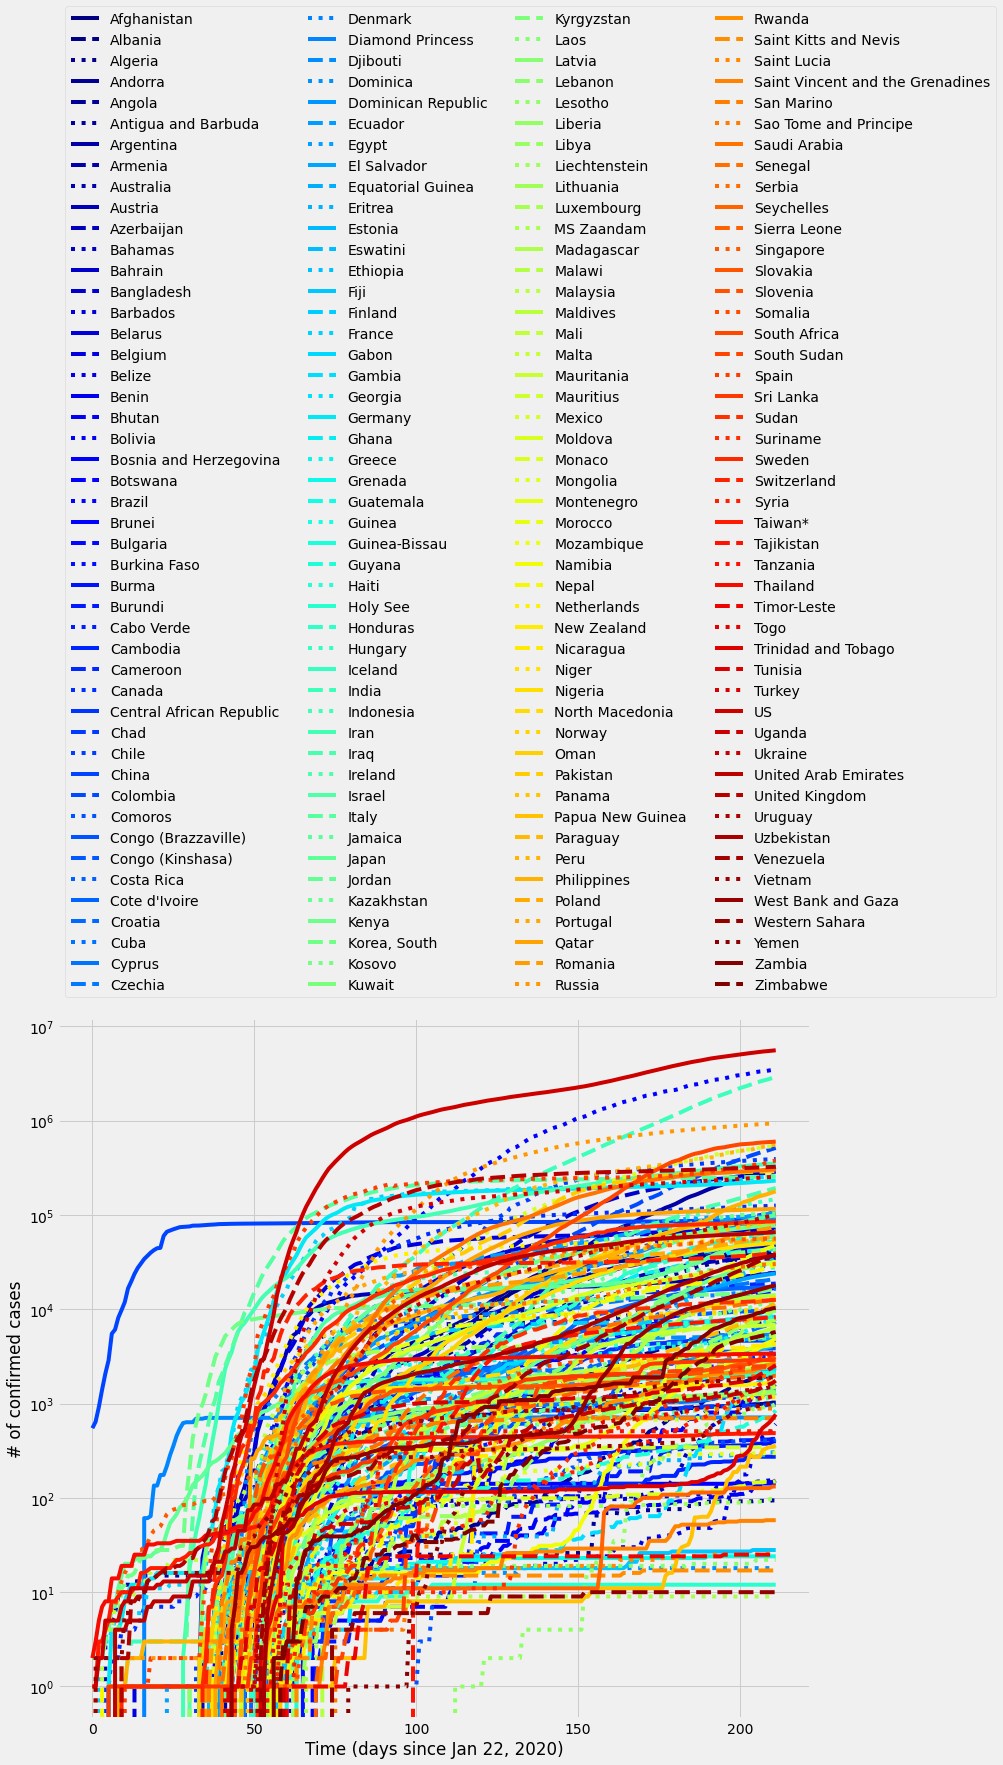

In [18]:
"""
Experiment summary
------------------
Treat each province/state in a country cases over time
as a vector, do a simple K-Nearest Neighbor between 
countries. What country has the most similar trajectory
to a given country?
"""

import sys
sys.path.insert(0, '..')

from utils import data
import os
import sklearn
import numpy as np
import json
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')


# ------------ HYPERPARAMETERS -------------
BASE_PATH = '../COVID-19/csse_covid_19_data/'
MIN_CASES = 1000
# ------------------------------------------

confirmed = os.path.join(
    BASE_PATH, 
    'csse_covid_19_time_series',
    'time_series_covid19_confirmed_global.csv')
confirmed = data.load_csv_data(confirmed)
features = []
targets = []

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cm = plt.get_cmap('jet')
NUM_COLORS = 0
LINE_STYLES = ['solid', 'dashed', 'dotted']
NUM_STYLES = len(LINE_STYLES)

for val in np.unique(confirmed["Country/Region"]):
    df = data.filter_by_attribute(
        confirmed, "Country/Region", val)
    cases, labels = data.get_cases_chronologically(df)
    cases = cases.sum(axis=0)

    if cases.sum() > MIN_CASES:
        NUM_COLORS += 1

colors = [cm(i) for i in np.linspace(0, 1, NUM_COLORS)]
legend = []
handles = []

for val in np.unique(confirmed["Country/Region"]):
    df = data.filter_by_attribute(
        confirmed, "Country/Region", val)
    cases, labels = data.get_cases_chronologically(df)
    cases = cases.sum(axis=0)

    if cases.sum() > MIN_CASES:
        i = len(legend)
        lines = ax.plot(cases, label=labels[0,1])
        handles.append(lines[0])
        lines[0].set_linestyle(LINE_STYLES[i%NUM_STYLES])
        lines[0].set_color(colors[i])
        legend.append(labels[0, 1])

ax.set_ylabel('# of confirmed cases')
ax.set_xlabel("Time (days since Jan 22, 2020)")

ax.set_yscale('log')
ax.legend(handles, legend, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4)
plt.tight_layout()
plt.savefig('results/cases_by_country.png')